<h1 style="color:red; font-weight:bold">Detecting Red Lights</h1>

<h4 style="color:white; font-weight:bold">Import libreries</h4>

In [77]:
# import the libraries:
from typing import List, Optional, Union, Dict, Tuple
import json
import argparse
from pathlib import Path
import cv2
import numpy as np
from scipy import signal as sg
from scipy.ndimage import maximum_filter, convolve
from PIL import Image,ImageDraw
import matplotlib.pyplot as plt

<h4 style="color:white; font-weight:bold">Making the blue sky to darker</h4>

In [78]:
def make_sky_black(image):
    # Convert the image to float
    img = np.array(image, dtype=float) / 255
    
    # Extract the blue channel
    blue_channel = img[:,:,2]
    
    # Create a kernel to detect the sky. 
    # This kernel is a simple averaging filter to smooth the image
    kernel = np.ones((5,5)) / 25
    
    # Convolve the blue channel with the kernel
    blue_smoothed = convolve(blue_channel, kernel)
    
    # Create a mask where the blue channel is above a certain threshold
    mask = blue_smoothed > 0.5
    
    # Apply the mask to all channels, setting them to 0 (black)
    img[mask] = 0
    
    # Convert back to 8-bit integer
    img_black_sky = (img * 255).astype(np.uint8)
    
    return Image.fromarray(img_black_sky)

In [79]:
# save the new image with black sky in 111.jpg
image_path = 'single_image/redLights.jpg'
image = Image.open(image_path)
black_sky_image = make_sky_black(image)
black_sky_image.save('111.jpg')

<h4 style="color:white; font-weight:bold">Upload the Image</h4>

In [80]:
# upload the image
img = plt.imread("111.jpg")
if img.max() <= 1:
    img = (img * 255).astype(np.uint8)

(843, 1500, 3)


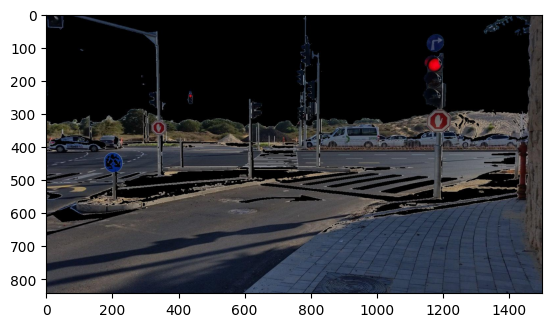

In [81]:
# show the image:
plt.imshow(img)

# print thre shape of the image:
print(img.shape)

In [82]:
# store the red channel of the image
red_img = img[:,:,0] 

# store the green channel of the image
green_img = img[:,:,1] 

# store the blue channel of the image
blue_img = img[:,:,2] 

In [83]:
print("img shape: ", img.shape)
print("red channel shape: ", red_img.shape)
print("green channel shape: ", green_img.shape)
print("blue channel shape: ", blue_img.shape)

img shape:  (843, 1500, 3)
red channel shape:  (843, 1500)
green channel shape:  (843, 1500)
blue channel shape:  (843, 1500)


In [84]:
# store the pixel value of the green light in txt file:
np.savetxt('pixel_red_img.txt', red_img, fmt='%d')

<h4 style="color:white; font-weight:bold">Show the image in green chanel and save it</h4>

In [85]:
# function that gets txt file  and save in red channel:
def save_red_channel(txt_file, output_image_file):
    # Read the data from the txt file
    data = np.loadtxt(txt_file, dtype=np.uint8)

    green_channel_image = data.reshape(data.shape[0], data.shape[1]) 

    # Create an RGB image with the red channel
    rgb_image = np.zeros((data.shape[0], data.shape[1], 3), dtype=np.uint8)
    rgb_image[:,:,0] = green_channel_image # 0-red channel, 1-green channel, 2-blue channel

    # Save the image to the specified file
    plt.imsave(output_image_file, rgb_image)


In [86]:
# function that gets txt file and show the image in red channel:

def show_red_channel(txt_file):
    # Read the data from the txt file
    data = np.loadtxt(txt_file, dtype=np.uint8)

    green_channel_image = data.reshape(data.shape[0], data.shape[1])

    # Create an RGB image with the red channel
    rgb_image = np.zeros((data.shape[0], data.shape[1], 3), dtype=np.uint8)
    rgb_image[:,:,0] = green_channel_image # 0-red channel, 1-green channel, 2-blue channel

    # Display the image
    plt.imshow(rgb_image)
    plt.axis('off') # to remove axis
    plt.show()    

In [87]:
save_red_channel("pixel_red_img.txt", "outputs_image_one_chanel/red_img.png")

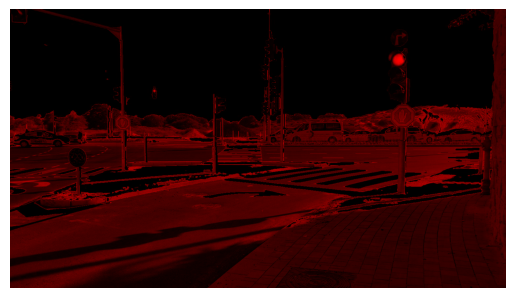

In [88]:
show_red_channel("pixel_red_img.txt")

<h4 style="color:white; font-weight:bold">Show the green chanel image after scale to gray</h4>

In [89]:
# function to show image from txt file - gray scale
def show_image(txt_file):
    # Read the data from the txt file
    data = np.loadtxt(txt_file, dtype=np.uint8)

    # Reshape the data into an image format (1024, 2048)
    # This assumes that a single channel (e.g., red) is stored in the file
    channel_image = data.reshape(data.shape[0], data.shape[1])

    # Create a greyscale image using the channel
    grey_image = np.stack([channel_image]*3, axis=-1)

    # Display the image
    plt.imshow(grey_image, cmap='gray')
    plt.axis('off') # to remove axis
    plt.show()


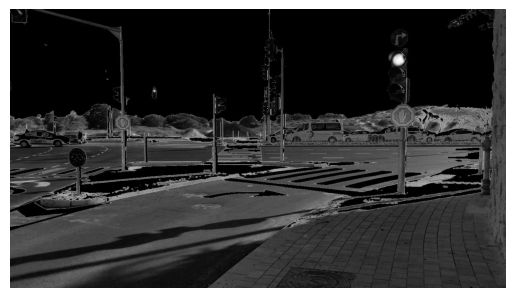

In [90]:
# show the image:
show_image("pixel_red_img.txt")

In [91]:
# function to save image from txt file - gray scale:
def save_image(txt_file, output_path):
    # Read the data from the txt file
    data = np.loadtxt(txt_file, dtype=np.uint8)

    # Reshape the data into an image format (1024, 2048)
    # This assumes that a single channel (e.g., red) is stored in the file
    channel_image = data.reshape(data.shape[0], data.shape[1])

    # Create a greyscale image using the channel
    grey_image = np.stack([channel_image]*3, axis=-1)

    # Save the image to the specified output path
    plt.imsave(output_path, grey_image, cmap='gray')

In [92]:
# save the image:
save_image("pixel_red_img.txt", "outputs_image_one_chanel/red_img_gray_scale.png")

<h4 style="color:white; font-weight:bold">Read the pixels from the txt file.</h4>

In [93]:
# function the read pixels form txt file to np array size nxm
def read_pixels(file_name):
    pixels = []
    with open(file_name, 'r') as f:
        for line in f:
            pixels.append(line.split())
    return np.array(pixels, dtype=np.uint8)

In [94]:
red_pixels = read_pixels("pixel_red_img.txt")

<h4 style="color:white; font-weight:bold">Apply New kernel to the green chanel image to Detect the green Lights</h4>

In [105]:
def mark_regions(numpy_pixels):
    # Convert the input 2D numpy array to a PIL image (grayscale)
    grayscale_image = Image.fromarray(numpy_pixels.astype('uint8'))

    # Create a new RGB image to draw the "X" marks on
    marked_image = grayscale_image.convert("RGB")
    
    # Initialize the drawing context
    draw = ImageDraw.Draw(marked_image)

    # Define the convolution kernel
    kernel = np.array([[1/9, 1/9, 1/9], [1/9, 1/9, 1/9], [1/9, 1/9, 1/9]])

    # Apply the convolution operation to get a score for each pixel
    score = convolve(numpy_pixels, kernel)

    # Loop through each pixel and mark the regions with an "X" mark
    height, width = numpy_pixels.shape
    for y in range(height):
        for x in range(width):
            # Check if the score is above a threshold to consider it a region to mark
            if score[y, x] > 200:
                # Draw a green "X" mark at the current pixel
                draw.line([(x - 5, y - 5), (x + 5, y + 5)], fill="green", width=2)
                draw.line([(x - 5, y + 5), (x + 5, y - 5)], fill="green", width=2)

    # Save the image
    marked_image.save("outputs_image_one_chanel/detection_red_lights.png")
    
    plt.imshow(marked_image, cmap='gray')
    plt.axis('off') # to remove axis
    plt.show()

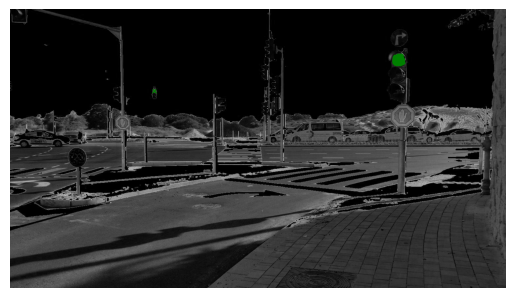

In [106]:
mark_regions(red_pixels)